# Validation

In order to further validate the promising results of the PLM classifier on the testing data, we sought to interrogate a well-characterized microbial genome using the model. To this end, we chose to analyze the complete genome of Escherichia coli (strain K-12, substrain. MG1655, assembly ASM584v2). The RefSeq accession for this genome is GCF_000005845.2. 

For organizational purposes, all data used for model validation is placed into a subdirectory within the data directory. If you want to run this code, be sure to modify the `DATA_DIR` variable below to specify where the data will be stored on your machine.


In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
# Add the selenobot/ subirectory to the module search path, so that the modules in this directory are visible from the notebook.
sys.path.append('../selenobot/')

from dataset import Dataset
from classifiers import Classifier
from utils import csv_size, dataframe_from_gff
from extend import extend
from plot import plot_training_curve
import pandas as pd
from typing import NoReturn
import numpy as np
import pickle

In [4]:
DATA_DIR = '/home/prichter/Documents/data/selenobot-test/validation/'

genome_id = 'GCF_000005845.2' # The accession of the genome to download. 
assembly = 'ASM584v2' # The specific genome assembly. 

## Downloading genome data

In [ ]:
# Download and unzip the genome data from NCBI. 
! curl 'https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/{genome_id}/download?include_annotation_type=GENOME_FASTA,PROT_FASTA,GENOME_GFF' -o '{DATA_DIR}ncbi_dataset.zip'
! unzip '{DATA_DIR}ncbi_dataset.zip' -d '{DATA_DIR}'

# Create a directory to store the genome files. 
! mkdir '{DATA_DIR}{genome_id}/' 
# Move the relevant files into the new directory for organizational purposes. 
! mv '{DATA_DIR}ncbi_dataset/data/{genome_id}/genomic.gff' -t '{DATA_DIR}{genome_id}/'
! mv '{DATA_DIR}ncbi_dataset/data/{genome_id}/protein.faa' -t '{DATA_DIR}{genome_id}/'
! mv '{DATA_DIR}ncbi_dataset/data/{genome_id}/{genome_id}_{assembly}_genomic.fna' '{DATA_DIR}{genome_id}/genome.fna'

# Remove some extraneous files which were also downloaded. 
! rm '{DATA_DIR}README.md'
! rm -R '{DATA_DIR}ncbi_dataset'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2655k    0 2655k    0     0   313k      0 --:--:--  0:00:08 --:--:--  340k
Archive:  /home/prichter/Documents/data/selenobot-test/validation/ncbi_dataset.zip
  inflating: /home/prichter/Documents/data/selenobot-test/validation/README.md  
  inflating: /home/prichter/Documents/data/selenobot-test/validation/ncbi_dataset/data/assembly_data_report.jsonl  
  inflating: /home/prichter/Documents/data/selenobot-test/validation/ncbi_dataset/data/GCF_000005845.2/GCF_000005845.2_ASM584v2_genomic.fna  
  inflating: /home/prichter/Documents/data/selenobot-test/validation/ncbi_dataset/data/GCF_000005845.2/protein.faa  
  inflating: /home/prichter/Documents/data/selenobot-test/validation/ncbi_dataset/data/GCF_000005845.2/genomic.gff  
  inflating: /home/prichter/Documents/data/selenobot-test/validation/ncbi_dataset/data/dataset_catalog.json

## Predicting selenoproteins

### Embedding the genes

### Running the PLM classifier

In [ ]:
df = dataframe_from_fasta(f'{DATA_DIR}protein.faa')
dataset = Dataset(df, embedder=None)

In [ ]:
model = Classifier(latent_dim=1024, hidden_dim=512)
model.load_state_dict(torch.load(f'{DATA_DIR}plm_model_weights.pth'))

In [ ]:
def load_genome(path:str) -> str:
    '''Load in the complete nucleotide sequence of the genome.
    
    :param path: A FASTA file from NCBI which contains a complete genome. 
    :return: A string of nucleotides. 
    '''
    with open(path, 'r') as f:
        lines = f.read().splitlines()[1:] # Skip the header line. 
        seq = ''.join(lines)
    return seq

In [ ]:
# Eventually, will need to be able to support this for a whole list of genomes.
def database_build_query() -> NoReturn:
    '''Build a query data database, which contains the sequences to search for homology matches for.'''
    # Grab the coordinate information about the predicted selenoproteins only. Exclude known selenoproteins.
    database = load_coordinates(gene_ids=[g for g in load_predictions() if g not in known_selenoproteins])
    # Mark the sequences which will be extended past the first STOP codon. 
    # database['extend'] = [(gene_id not in known_selenoproteins) for gene_id in database.gene_id]
    database['extend'] = True 
    database = get_sequences(database, load_genome('', path=os.path.join(DATA_DIR, 'genome.fasta')))
    database_write(database, filename='query.fasta')


def database_build_control() -> NoReturn:
    '''Build a control query data database, which contains the non-extended selenoprotein sequences.'''
    # Grab the coordinate information about the predicted selenoproteins only. Exclude known selenoproteins.
    database = load_coordinates(gene_ids=[id_ for id_ in load_predictions() if id_ not in known_selenoproteins])
    database['extend'] = False # Don't extend anything here. 
    database = get_sequences(database, load_genome('', path=os.path.join(DATA_DIR, 'genome.fasta')))
    database_write(database, filename='control.fasta')

In [ ]:
! pip install -e /home/prichter/Documents/find-a-bug-api

Obtaining file:///home/prichter/Documents/find-a-bug-api
  Preparing metadata (setup.py) ... done
  Attempting uninstall: Find-A-Bug-API
    Found existing installation: Find-A-Bug-API 0.0.0
    Uninstalling Find-A-Bug-API-0.0.0:
      Successfully uninstalled Find-A-Bug-API-0.0.0
  Running setup.py develop for Find-A-Bug-API


In [ ]:
from align import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import fabapi
import fabapi.genomes

In [ ]:
# Load in the query sequences from the query.fasta file. These sequences have been extended past the STOP codon. 
ydhv_seq = mmseqs_load_sequence_from_database('ydhV')
ydhv_seq_non_extended = ydhv_seq.split('U')[0]
ydhv_u_pos = ydhv_seq.index('U') # Get the position of the putative selenocysteine.

In [ ]:
# This function loads in the data from mmseqs.csv, which contains the start and stop regions of the hits relative to both
# the query and target sequences, the target gene IDs, and the full-length target sequences (downloaded using Find-A-Bug).
mmseqs_data = pd.read_csv(os.path.join(DATA_DIR, 'mmseqs', 'mmseqs.csv'), index_col=0)
mmseqs_data = mmseqs_data[mmseqs_data.query_gene_id == 'ydhV']
print('Columns in MMSeqs2 data:\n\n' + '\n'.join(mmseqs_data.columns))

Columns in MMSeqs2 data:

target_gene_id
seq_identity
alignment_length
num_mismatches
num_gap_openings
query_domain_start
query_domain_stop
target_domain_start
target_domain_stop
e_value
bit_score
query_gene_id
query_nt_ext
query_aa_length
query_aa_ext
split
query_u_position
past_stop_codon
target_seq


In [ ]:
print('Number of MMSeqs2 hits:', len(mmseqs_data))
print('Number of unique hits:', len(set(mmseqs_data.target_gene_id)))
print('Number of hits past the stop codon:', sum(mmseqs_data.past_stop_codon))

Number of MMSeqs2 hits: 9600
Number of unique hits: 9600
Number of hits past the stop codon: 163


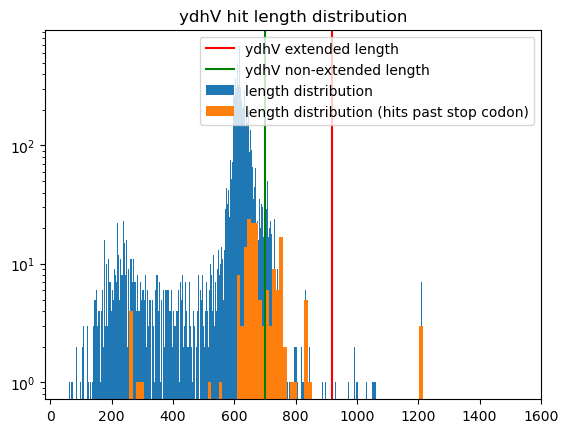

In [ ]:
mmseqs_hit_lengths = mmseqs_data.target_seq.apply(len).values
mmseqs_hit_lengths_past_stop_codon = mmseqs_data[mmseqs_data.past_stop_codon].target_seq.apply(len).values 

fig, ax = plt.subplots(1)
ax.hist(mmseqs_hit_lengths, bins=len(set(mmseqs_hit_lengths)))
ax.hist(mmseqs_hit_lengths_past_stop_codon, bins=len(set(mmseqs_hit_lengths_past_stop_codon)))
ax.set_title(f'ydhV hit length distribution')
ax.axvline(len(ydhv_seq), c='red')
ax.axvline(len(ydhv_seq_non_extended), c='green')
ax.legend([ 'ydhV extended length', 'ydhV non-extended length', 'length distribution', 'length distribution (hits past stop codon)'])
ax.set_yscale('log')
plt.show()

In [ ]:
# Generate pairwise alignments for each of the candidates.
get_pairwise_alignments(ydhv_seq, mmseqs_data[mmseqs_data.past_stop_codon], filename='mmseqs_alignments_ydhv.csv')

homology.get_pairwise_alignments: Unable to generate alignments for 163 target genes.


In [ ]:
# Filter the data according to both the length of the target sequence and whether or not the hit spans the selenocysteine. 
mmseqs_data = mmseqs_data[mmseqs_data.past_stop_codon]
mmseqs_data = mmseqs_data[mmseqs_data.target_seq.apply(len) > 800] # Length cutoff from eyeballing the distribution. 

print('Number of target sequences which meet the length and hit location requirements:', len(mmseqs_data))
print('\n' + '\n'.join(list(mmseqs_data.target_gene_id)))
# I should look into the KO groups and other data for these particular genes. 

Number of target sequences which meet the length and hit location requirements: 9

JACTUC010000002.1_23
PRDJ01000036.1_86
DRYY01000068.1_6
JAEORN010000318.1_13
JACIVQ010000013.1_25
QNVH01000006.1_12
QNVI01000016.1_50
VGLU01000004.1_4
PRDI01000058.1_30


In [ ]:
blast_build_target(mmseqs_data, filename='target_ydhv.fasta')
blast_build_query('ydhV', ydhv_seq, filename='query_ydhv.fasta')
# Run blastp on the query and target, and write the output to a TSV file at the specified filename. 
blast_run('query_ydhv.fasta', 'target_ydhv.fasta', 'results_ydhv.tsv')

In [ ]:
# Load in the data from running pairwise alignments of ydhV against the nine sequences from above.
blast_data = blast_load_results('results_ydhv.tsv')
blast_data.head()

align.blast_load_results: Alignments for DRYY01000068.1_6, VGLU01000004.1_4 do not cover selenocysteine, and were removed.


,percentage_identical,align_length,num_mismatches,num_gap_openings,query_align_start,query_align_stop,target_align_start,target_align_stop,e_value,bit_score,query_align_seq,target_align_seq,target_gene_id,query_gene_id,u_pos,u_overlap
0,26.852,756,436,26,4,732,3,668,2.290000e-50,183.0,GWTGNILRVNLTTGNITLE--DSSKFKSFVGGMGFGYKIMYDEVPP...,GYMGRILRINLATSTITEEFPDEETLRKYLGGAGLATKILIEETEK...,PRDJ01000036.1_86,ydhV,715,G
2,26.635,841,500,35,7,838,2,734,4.310000e-49,177.0,GNILRVNLTTGNITLED--SSKFKSFVGGMGFGYKIMYDEVPPGTK...,GKILRVDLSSREISVEDLDMDVAASFVGGRGYGAKILFEELPVGID...,QNVH01000006.1_12,ydhV,703,V
3,26.240,766,417,24,4,728,3,661,6.830000e-49,178.0,GWTGNILRVNLTTGNITLE--DSSKFKSFVGGMGFGYKIMYDEVPP...,GYMGKILRVNLTTGSITEEFPDEETLRKYLGGSGLATKYLFEETEP...,JAEORN010000318.1_13,ydhV,733,Q
4,26.876,733,412,20,4,709,3,638,8.150000e-49,178.0,GWTGNILRVNLTTGNITLE--DSSKFKSFVGGMGFGYKIMYDEVPP...,GYMGKILRINLTTSTITEEFPDEETLRKYLGGAGLATKILLEETEK...,PRDI01000058.1_30,ydhV,724,G
5,25.235,852,506,34,3,838,2,738,1.130000e-47,173.0,NGWTGNILRVNLTTGNITLEDSSK--FKSFVGGMGFGYKIMYDEVP...,NGYMGKILRVDLSSKEISIEELNMDIAYQFIGGRGYGAKVLFDELP...,QNVI01000016.1_50,ydhV,714,V


In [ ]:
for row in blast_data.itertuples():
    print(row.target_gene_id, '\t', row.u_overlap)

PRDJ01000036.1_86 	 G
QNVH01000006.1_12 	 V
JAEORN010000318.1_13 	 Q
PRDI01000058.1_30 	 G
QNVI01000016.1_50 	 V
JACIVQ010000013.1_25 	 V
JACTUC010000002.1_23 	 V


In [ ]:
# def download_ko(gene_id:str) -> List[str]:
#     '''Obtains the KO group(s) for the gene ID from the Find-A-Bug database.'''
#     url = f'http://microbes.gps.caltech.edu:8000/api/annotations?gene_id={gene_id}'
#     response = requests.get(url).text
#     kos = pd.read_csv(StringIO(response), index_col=0).ko
#     return list(kos)

# for row in blast_data.itertuples():
#     print(row.target_gene_id, download_ko(row.target_gene_id))

In [ ]:
# For generating the figure for the homology-based validation. Print the window around the selenocysteine residue. 
d = 25 # Number many residues on either side of the selenocysteine. 

ydhv_window = ydhv_seq[ydhv_u_pos - d:ydhv_u_pos + d + 1]
ydhv_window = ydhv_window[:d] + f'[{ydhv_window[d]}]' + ydhv_window[d + 1:]
print('ydhv', ydhv_u_pos - d, ydhv_window, ydhv_u_pos + d + 1)

for row in blast_data.itertuples():
    
    window = row.target_align_seq[row.u_pos - d:min(row.u_pos + d + 1, len(row.target_align_seq))]
    window = window[:d] + f'[{window[d]}]' + window[d + 1:]
    # U position in the rows is relative to the start of the ALIGNMENT, not the sequence itself.
    start = row.target_align_start + row.u_pos - d
    stop = row.target_align_start + min(row.u_pos + d + 1, len(row.target_align_seq))
    print(row.target_gene_id, start, window , stop)

ydhv 675 TRETLQRLGLEDIAADLAAHNLLPA[U]GMGKMNHQDELPLAKVSEVDEAKRQ 726
PRDJ01000036.1_86 693 TVEKLKELGLEWVAGSIPEYGGFGR[G]TTGAQMKQVATSDNETAGAVPAASV 744
QNVH01000006.1_12 680 TDKKVSQLGLKPLYEGPKXQ-----[V]AIDERYLKDALPIA------EASYR 731
JAEORN010000318.1_13 711 TVEKLKELDLEWL-VDVVHGDIAPI[Q]EIVRQKAKDLPAIERKSTSAGMEVK 762
PRDI01000058.1_30 702 SREKLKELDLAWVADSIPEYGDLGR[G]TTGAQTKQ 736
QNVI01000016.1_50 691 TDKKVLELGLTPLYDGPKIQ-----[V]AIDERYMKDALPIA------EAAYR 742
JACIVQ010000013.1_25 691 TDKKVSQLGLKPLYEGPKLQ-----[V]AIDERYLKDALPIA------EASYR 742
JACTUC010000002.1_23 608 TDRRVTKLGLKPLYEGPKLQ-----[V]AIDERYLKDALPIAEGAYRGGAEII 659


In [ ]:
# Getting the taxonomy of each gene. 
genome_ids = []
for row in blast_data.itertuples():
    # Get the genome where the gene is found. 
    genome_id = fabapi.get_genome_id_with_gene_id(row.target_gene_id)
    genome_ids.append(genome_id) # Store the genome ID. 

    taxonomy = fabapi.get_gtdb_taxonomy_with_genome_id(genome_id)
    print('Gene ID:', row.target_gene_id)
    print('Genome ID:', genome_id)
    for col in [col for col in taxonomy.columns if col not in ['gtdb_species', 'gtdb_genus', 'genome_id']]:
        print(f'{col}:', taxonomy[col].item())
    print()

# Add the genome IDs to the DataFrame for use later. 
blast_data['genome_id'] = genome_ids

Gene ID: PRDJ01000036.1_86
Genome ID: GCA_003345555.1
gtdb_family: Thorarchaeaceae
gtdb_domain: Archaea
gtdb_class: Thorarchaeia
gtdb_order: Thorarchaeales
gtdb_phylum: Asgardarchaeota

Gene ID: QNVH01000006.1_12
Genome ID: GCA_004347955.1
gtdb_family: Methanomethylicaceae
gtdb_domain: Archaea
gtdb_class: Methanomethylicia
gtdb_order: Methanomethylicales
gtdb_phylum: Thermoproteota

Gene ID: JAEORN010000318.1_13
Genome ID: GCA_016840825.1
gtdb_family: Thorarchaeaceae
gtdb_domain: Archaea
gtdb_class: Thorarchaeia
gtdb_order: Thorarchaeales
gtdb_phylum: Asgardarchaeota

Gene ID: PRDI01000058.1_30
Genome ID: GCA_003345595.1
gtdb_family: Thorarchaeaceae
gtdb_domain: Archaea
gtdb_class: Thorarchaeia
gtdb_order: Thorarchaeales
gtdb_phylum: Asgardarchaeota

Gene ID: QNVI01000016.1_50
Genome ID: GCA_004348015.1
gtdb_family: Methanomethylicaceae
gtdb_domain: Archaea
gtdb_class: Methanomethylicia
gtdb_order: Methanomethylicales
gtdb_phylum: Thermoproteota

Gene ID: JACIVQ010000013.1_25
Genome ID

In [ ]:
# What are the stop codons for each genome?
genome_dir = '/home/prichter/Documents/data/selenobot/validation/homology/genomes/'

# for row in blast_data.itertuples():
#     # Download the genome assembly from NCBI database.
#     fabapi.genomes.download_genome(row.genome_id, output_dir=genome_dir)

In [ ]:
# Stop codons are UAA, UAG and UGA
for row in blast_data.itertuples():
    genome = fabapi.genomes.load_genome(os.path.join(genome_dir, row.genome_id))
    seq_data = fabapi.get_sequence_with_gene_id(row.target_gene_id)
    # Get the start and stop codon, accounting for whether or not the sequence is read in reverse.
    nt_start, nt_stop = seq_data.nt_start.item(), seq_data.nt_stop.item()
    if seq_data.reverse.item() == 0:
        print(genome[nt_stop - 3:nt_stop], '(forward)')
    else:
        print(genome[nt_start - 1:nt_start + 2], '(reverse)')
    
    

GGT (reverse)
ACA (forward)
ATG (forward)
TCC (reverse)
AAT (forward)
TGA (forward)
CGC (forward)


In [ ]:
def download_genome(genome_id:str, output_dir:str='.') -> NoReturn:
    '''Download a genome assembly from the NCBI database to the output directory. 
    
    :param genome_id: The accession of the genome to download.
    :param output_dir: The directory to which the genome data will be downloaded. Uses the 
        current directory by default.
    '''
    url = f'https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/{genome_id}/download?include_annotation_type=GENOME_FASTA'

    if os.path.exists(os.path.join(output_dir, genome_id) ):
        raise Exception(f'genomes.download_genome: Genome directory for {genome_id} already exists.')
    
    zip_file = f'{genome_id}.zip' # Output zip file for download from NCBI.

    # Run curl to download the zip file to the output directory. 
    subprocess.run(f'curl {url} --output {os.path.join(output_dir, zip_file)}', shell=True, check=True)
    # Extract the zip file to a new directory, titled using the genome ID. 
    subprocess.run(f'mkdir {os.path.join(output_dir, genome_id)}', shell=True, check=True)
    subprocess.run(f'unzip {os.path.join(output_dir, zip_file)} -d {os.path.join(output_dir, genome_id)}', shell=True, check=True)


def load_genome(path:str) -> str:
    '''Load a downloaded genome from the directory at the specified path. The directory should be one which
    was created using the download_genome function, or of the same structure (i.e. that of the default NCBI genome download).

    :param path: The path to the directory in which the NCBI genome information is stored. Assumes the name of the directory
        is the genome ID. 
    :return: A string of A, C, T, and G, representing the entire genome assembly. 
    '''
    genome_id = os.path.basename(path)

    # Get the complete path to the genome FASTA file stored in directory. 
    path_to_genome_file = os.path.join(path, f'ncbi_dataset/data/{genome_id}') # Should only be one file in this directory. 
    genome_filename = os.listdir(path_to_genome_file)[0]

    pass
